In [7]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import re
from selenium import webdriver

import random
from matplotlib import pyplot as plt
from jupyterthemes import jtplot
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [8]:
def getHtml(url):
    driver = webdriver.Edge(executable_path = 'C:\\Users\\Home\\Documents\\msedgedriver.exe') # используем Selenium
    driver.get(url)
    
    try:
        lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")
        match=False
        for j in range(500):
            lastCount = lenOfPage
            delay = random.randint(10, 30) / 10
            time.sleep(delay)
            lenOfPage = driver.execute_script("window.scrollTo(0, document.body.scrollHeight);var lenOfPage=document.body.scrollHeight;return lenOfPage;")

    except Exception as e:
        print(e)

    time.sleep(1)
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    driver.close()
    rows = soup.find('div', id="search_resultsRows")
    return rows

In [9]:
def getData(href):
    labels = []
    temp = requests.post(href)
    soup = BeautifulSoup(temp.text, 'html.parser')
    
    try:
        page = soup.find('div', class_="glance_tags_ctn popular_tags_ctn")
        for label in page.find_all('a'):
            labels.append(label.text.split('\t\t\t\t\t\t\t\t\t\t\t\t')[1])
    except:
        pass
    return labels

In [10]:
def getRows(game_type, page):
    result = []
    i = 0
    
    for game in page.find_all('a'):
        i += 1
        if i > 6000:
            return result
        else:
            try:

                href = game.attrs.get('href')
                
                review_data = game.find('span', class_=re.compile('search_review_summary')).attrs.get('data-tooltip-html').split('<br>')
                
                title = game.find('span', class_="title").text
                price = float(game.find('div', class_="col search_price_discount_combined responsive_secondrow").attrs.get('data-price-final'))
                release_date = game.find('div', class_="col search_released responsive_secondrow").text
                review_type = review_data[0]
                rating = review_data[1].split(' ')[0]
                review_count = review_data[1].split(' ')[3]
                labels = getData(href)
                
                result.append([title, price, labels, game_type, release_date, review_type, rating, review_count])

            except Exception as e:
                pass
                    
    #return result

In [44]:
jtplot.style(theme='oceans16', context='notebook', ticks=True, grid=False)

## Сделаем запрос по тегу "Инди":

In [12]:
indie_page = getHtml('https://store.steampowered.com/search/?tags=492&category1=998')

In [13]:
indie_games = getRows("indie", indie_page)

In [14]:
indie_games1 = getRows("indie", indie_page)

In [15]:
df1 = pd.DataFrame(indie_games1)


## Затем запрос, исключающий этот тег:

In [16]:
AAA_page = getHtml('https://store.steampowered.com/search/?untags=492&category1=998')

In [17]:
AAA_games = getRows("AAA", AAA_page)

### Сформируем таблицу в pandas

In [18]:
cols = ['Название', 'Цена', 'Метки', 'Тип', 'Дата выхода', 'Отзывы', 'Рейтинг', 'Число отзывов']

all_games = indie_games + AAA_games
df = pd.DataFrame(all_games, columns=cols)

In [150]:
df

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
0,Phasmophobia,309.0,"[Horror, Online Co-Op, Multiplayer, Psychologi...",indie,2020-09-18,Overwhelmingly Positive,97%,"339,441"
1,Rust,3000.0,"[Survival, Crafting, Multiplayer, Open World, ...",indie,2018-02-08,Very Positive,87%,"620,455"
2,DayZ,1199.0,"[Survival, Zombies, Multiplayer, Open World, A...",indie,2018-12-13,Mostly Positive,71%,"249,404"
3,ARK: Survival Evolved,169.0,"[Open World Survival Craft, Survival, Open Wor...",indie,2017-08-27,Very Positive,82%,"410,820"
4,Risk of Rain 2,799.0,"[Third-Person Shooter, Action Roguelike, Multi...",indie,2020-08-11,Overwhelmingly Positive,96%,"130,405"
...,...,...,...,...,...,...,...,...
11989,Mystery Case Files: The Countess Collector's E...,259.0,"[Adventure, Casual, Hidden Object]",AAA,2018-11-27,Mixed,66%,15
11990,Bunker Defense,465.0,"[Early Access, Strategy, Tower Defense, Online...",AAA,2020-10-14,Positive,93%,16
11991,Be Hero,299.0,"[Early Access, RPG, Farming Sim, Crafting, Cut...",AAA,2021-03-30,Positive,93%,29
11992,Rift Coaster HD Remastered VR,29.0,"[Casual, Simulation, VR]",AAA,2017-08-09,Mixed,40%,76


## Устраним пустоты в полученных данных 

In [20]:
df = df.convert_dtypes()
df['Цена'] = df['Цена'].astype(float)
df['Цена'] = df['Цена'] / 100

In [21]:
d1 = pd.to_datetime(df['Дата выхода'], format="%d %b, %Y", errors='coerce')
d2 = pd.to_datetime(df['Дата выхода'], format="%b %Y", errors='coerce')

df['Дата выхода'] = d1.combine_first(d2)

In [154]:
df['Метки'] = df['Метки'].astype(str)
df = df.drop(df[df['Метки'] == '[]'].index)

In [155]:
df

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
0,Phasmophobia,309.0,"['Horror', 'Online Co-Op', 'Multiplayer', 'Psy...",indie,2020-09-18,Overwhelmingly Positive,97%,"339,441"
1,Rust,3000.0,"['Survival', 'Crafting', 'Multiplayer', 'Open ...",indie,2018-02-08,Very Positive,87%,"620,455"
2,DayZ,1199.0,"['Survival', 'Zombies', 'Multiplayer', 'Open W...",indie,2018-12-13,Mostly Positive,71%,"249,404"
3,ARK: Survival Evolved,169.0,"['Open World Survival Craft', 'Survival', 'Ope...",indie,2017-08-27,Very Positive,82%,"410,820"
4,Risk of Rain 2,799.0,"['Third-Person Shooter', 'Action Roguelike', '...",indie,2020-08-11,Overwhelmingly Positive,96%,"130,405"
...,...,...,...,...,...,...,...,...
11989,Mystery Case Files: The Countess Collector's E...,259.0,"['Adventure', 'Casual', 'Hidden Object']",AAA,2018-11-27,Mixed,66%,15
11990,Bunker Defense,465.0,"['Early Access', 'Strategy', 'Tower Defense', ...",AAA,2020-10-14,Positive,93%,16
11991,Be Hero,299.0,"['Early Access', 'RPG', 'Farming Sim', 'Crafti...",AAA,2021-03-30,Positive,93%,29
11992,Rift Coaster HD Remastered VR,29.0,"['Casual', 'Simulation', 'VR']",AAA,2017-08-09,Mixed,40%,76


## Анализируем данные

### 1. Распределение по типам

([<matplotlib.patches.Wedge at 0x1bca21c02e0>,
 [Text(-0.004772721318962695, 1.0999896459200023, 'indie'),
  Text(0.004772721318962316, -1.0999896459200023, 'AAA')],
 [Text(-0.002603302537616015, 0.5999943523200011, '50%'),
  Text(0.0026033025376158087, -0.5999943523200011, '50%')])

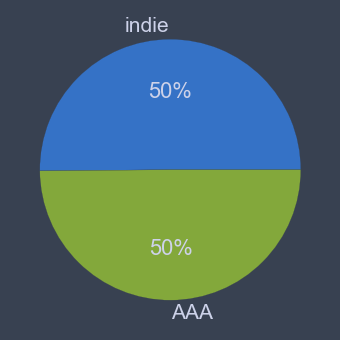

In [157]:
plt.pie(df['Тип'].value_counts(), labels = df['Тип'].unique(), autopct='%.0f%%')

## 1. Цены

### 1.1 Средняя цена игры

In [161]:
df[['Цена']].apply(np.median)

Цена    259.0
dtype: float64

In [162]:
df[df['Тип'] == 'indie'][['Цена']].apply(np.median)

Цена    259.0
dtype: float64

In [163]:
df[df['Тип'] == 'AAA'][['Цена']].apply(np.median)

Цена    259.0
dtype: float64

### 1.2. Зависимость между типом и ценой

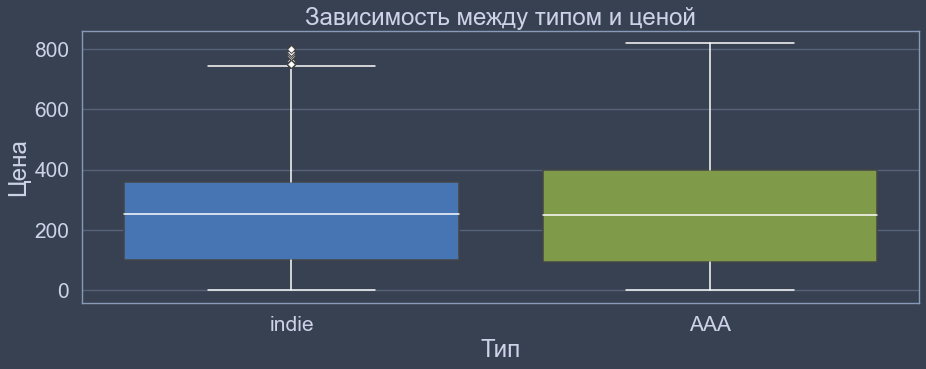

In [164]:
#sns.set(font_scale=2)
green_diamond = dict(markerfacecolor='w', marker='D')
fig, ax1 = plt.subplots(figsize=(15,5))
jtplot.style(context='notebook', ticks=True, grid=True, fscale=2, figsize=(15,6), theme='oceans16')
sns.boxplot(x ='Тип', y ='Цена', data = df.loc[df['Цена']<df['Цена'].quantile(0.95)], flierprops=green_diamond).set_title('Зависимость между типом и ценой')
for line in ax1.get_lines():
    line.set_color('white')
plt.show()

### 1.3 Самые дорогие игры 

In [165]:
df.sort_values(by = 'Цена', ascending = False).head(10)

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
10577,Mosaic: Game of Gods,99999.00,"['Casual', 'Puzzle', 'God Game']",AAA,2016-10-31,Very Positive,94%,54
2260,Legend of Himari,10000.00,"['Indie', 'Casual', 'Anime', 'Female Protagoni...",indie,2018-03-19,Very Positive,89%,247
2509,The Orphan Dreams,9999.00,"['Adventure', 'Casual', 'Indie', 'RPG']",indie,2016-04-27,Mostly Positive,78%,19
4292,Yandere School,6666.00,"['Anime', 'Action', 'Indie', 'Sexual Content',...",indie,2017-09-01,Mixed,61%,273
769,RealFlight 9.5S,5098.32,"['Simulation', 'Indie', 'Racing', 'Flight', 'VR']",indie,2021-12-07,Very Positive,80%,338
7674,A-Train: All Aboard! Tourism,4499.00,"['Simulation', 'Trains', 'Immersive Sim', 'Cit...",AAA,2021-12-08,Mostly Positive,70%,72
8475,Re:ZERO -Starting Life in Another World- The P...,4198.00,"['Adventure', 'Anime', 'Visual Novel', 'Strate...",AAA,2021-01-28,Very Positive,87%,377
6000,ELDEN RING,3999.00,"['Souls-like', 'Relaxing', 'Dark Fantasy', 'RP...",AAA,2022-02-24,Very Positive,89%,"325,013"
7161,Ys IX -Monstrum NOX-,3929.00,"['Action', 'RPG', 'JRPG', 'Action RPG', '3D', ...",AAA,2022-01-19,Very Positive,89%,69
9203,AFL Evolution 2,3699.00,"['Sports', 'Simulation', 'Singleplayer', 'PvP'...",AAA,2020-09-11,Very Positive,80%,122


## 2. Отзывы

### 2.1 Общая статистика

In [29]:
df['Отзывы'].value_counts()

Very Positive              6027
Mostly Positive            2053
Mixed                      1611
Positive                   1582
Overwhelmingly Positive     715
Mostly Negative               4
Overwhelmingly Negative       2
Name: Отзывы, dtype: Int64

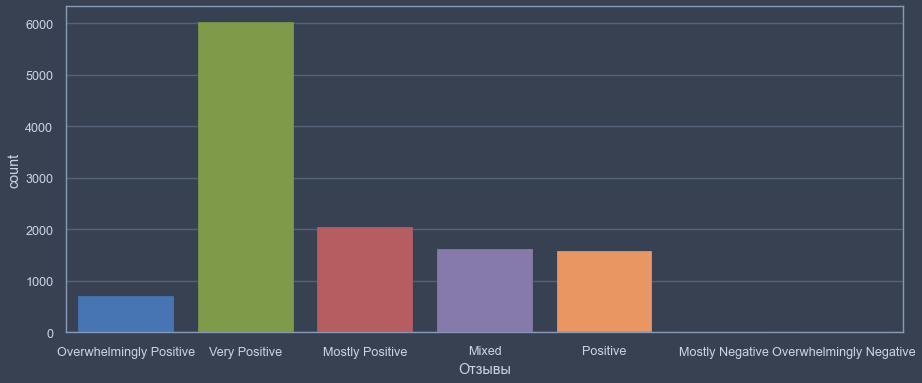

In [74]:
sns.countplot(df['Отзывы'])
jtplot.style(context='notebook', ticks=True, grid=True, fscale=1.2, figsize=(15,6), theme='oceans16')

### 2.2 Самый высокий рейтинг

In [166]:
df1 = df.copy()
df1[df1['Рейтинг'] == '100%']

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
184,Ib,299.0,"['Female Protagonist', '2D', 'Horror', 'Cute',...",indie,2022-04-11,Very Positive,100%,197
1614,FIND ALL 2: Middle Ages,66.0,"['Hidden Object', 'Casual', 'Hand-drawn', 'Col...",indie,2022-03-03,Positive,100%,36
1707,COSPLAY LOVE! : Enchanted princess,973.0,"['Adventure', 'Visual Novel', 'Dating Sim', 'C...",indie,2022-03-30,Positive,100%,10
1763,Tentacular,699.0,"['Casual', 'VR', 'Funny', 'Building', 'Puzzle'...",indie,2022-03-24,Positive,100%,10
1769,The Last Cube,435.0,"['3D Platformer', 'Puzzle Platformer', 'Puzzle...",indie,2022-03-10,Very Positive,100%,55
...,...,...,...,...,...,...,...,...
11959,Corridor 7: Alien Invasion,259.0,"['Retro', 'Aliens', 'FPS', 'Shooter', 'Pixel G...",AAA,2021-08-06,Positive,100%,11
11970,Castle on the Coast,515.0,"['3D Platformer', 'Collectathon', 'Retro', 'Cu...",AAA,2021-12-02,Positive,100%,14
11978,Amazing Fix,259.0,"['Early Access', 'Casual', 'Puzzle', 'Hidden O...",AAA,2021-04-14,Positive,100%,20
11979,Mahjong Solitaire Refresh,435.0,"['Casual', 'Puzzle']",AAA,2019-09-12,Positive,100%,10


In [173]:
df1['Рейтинг'] = (df1['Рейтинг'].str.split('%').str[0]).astype(float)

In [174]:
jtplot.style(context='notebook', ticks=True, grid=True, fscale=2, figsize=(15,6), theme='oceans16')

Text(0.5, 1.0, 'Распределение рейтинга')

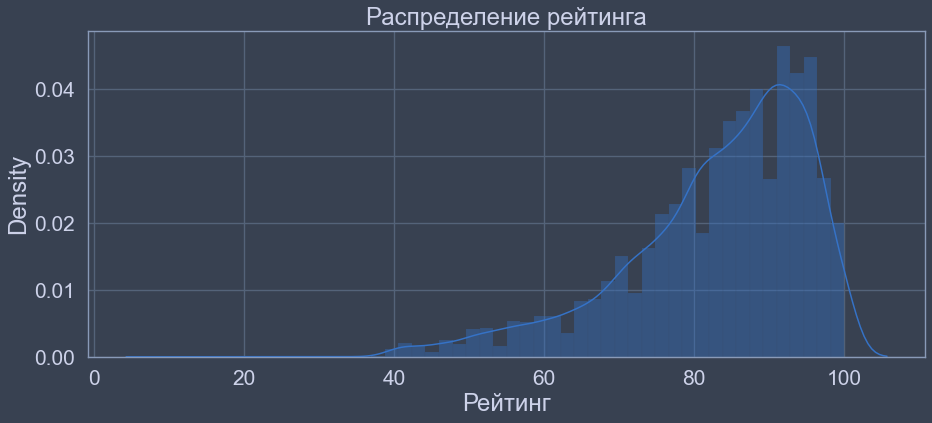

In [175]:
sns.distplot(df1['Рейтинг']).set_title('Распределение рейтинга')

### 2.3 А что будет, если посчитаем рейтинг только тех игр, у которых больше 1000 отзывов?

In [176]:
df_1000_review = df1.copy()
df_1000_review['Число отзывов'] = df_1000_review['Число отзывов'].replace(to_replace =',', value = '', regex = True).astype(int)
df_1000_review = df_1000_review[df_1000_review['Число отзывов'] > 1000]
df_1000_review

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
0,Phasmophobia,309.0,"['Horror', 'Online Co-Op', 'Multiplayer', 'Psy...",indie,2020-09-18,Overwhelmingly Positive,97.0,339441
1,Rust,3000.0,"['Survival', 'Crafting', 'Multiplayer', 'Open ...",indie,2018-02-08,Very Positive,87.0,620455
2,DayZ,1199.0,"['Survival', 'Zombies', 'Multiplayer', 'Open W...",indie,2018-12-13,Mostly Positive,71.0,249404
3,ARK: Survival Evolved,169.0,"['Open World Survival Craft', 'Survival', 'Ope...",indie,2017-08-27,Very Positive,82.0,410820
4,Risk of Rain 2,799.0,"['Third-Person Shooter', 'Action Roguelike', '...",indie,2020-08-11,Overwhelmingly Positive,96.0,130405
...,...,...,...,...,...,...,...,...
11883,Jesus Christ RPG Trilogy,0.0,"['Illuminati', 'Memes', 'Psychological Horror'...",AAA,2016-03-18,Very Positive,85.0,1477
11914,Bloodline Champions,0.0,"['Free to Play', 'Action', 'MOBA', 'Multiplaye...",AAA,2011-10-28,Very Positive,85.0,1646
11920,Disturbed,0.0,"['Free to Play', 'Horror', 'Adventure', 'Visua...",AAA,2016-10-03,Very Positive,92.0,1638
11934,War of the Three Kingdoms,0.0,"['Sexual Content', 'Psychological Horror', 'Nu...",AAA,2021-12-17,Overwhelmingly Negative,10.0,13705


In [178]:
df_1000_review[df_1000_review['Рейтинг'] > 98]

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
1052,A Short Hike,195.0,"['Adventure', 'Exploration', 'Indie', 'Cute', ...",indie,2019-07-30,Overwhelmingly Positive,99.0,8473
4435,Aventura Copilului Albastru și Urât,61.0,"['Adventure', 'Hentai', 'Sexual Content', '2D'...",indie,2021-02-08,Overwhelmingly Positive,99.0,1815
6186,ULTRAKILL,435.0,"['Early Access', 'FPS', 'Arena Shooter', 'Spec...",AAA,2020-09-03,Overwhelmingly Positive,99.0,20380
6400,Senren＊Banka,899.0,"['Casual', 'Adventure', 'Visual Novel', 'Anime...",AAA,2020-02-14,Overwhelmingly Positive,99.0,7908
6664,Sucker for Love: First Date,259.0,"['Visual Novel', 'Romance', 'Dating Sim', 'RPG...",AAA,2022-01-20,Overwhelmingly Positive,99.0,1142
6810,Maitetsu:Last Run!!,1459.0,"['Sexual Content', 'Casual', 'Visual Novel', '...",AAA,2020-10-30,Overwhelmingly Positive,99.0,1586
11390,Project Kat - Paper Lily Prologue,0.0,"['Anime', 'Psychological Horror', 'Pixel Graph...",AAA,2021-10-16,Overwhelmingly Positive,99.0,2527


### 2.4 Зависимость между типом и отзывами

<AxesSubplot:xlabel='Отзывы', ylabel='count'>

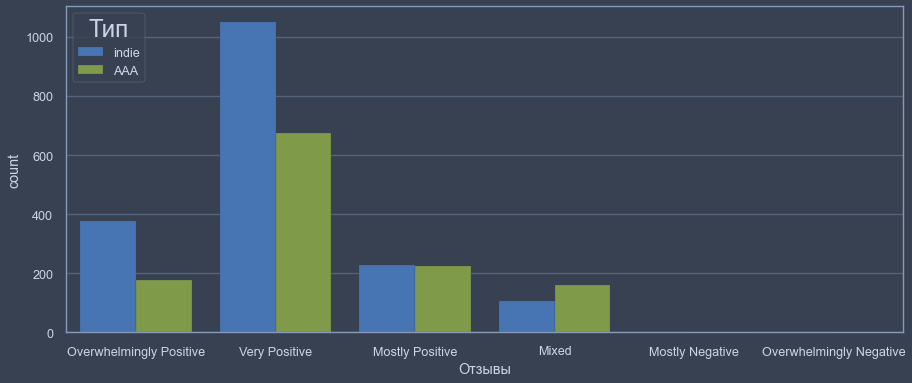

In [82]:
jtplot.style(context='notebook', ticks=True, grid=True, fscale=1.2, figsize=(15,6), theme='oceans16')
sns.countplot(x='Отзывы', hue='Тип', data = df_1000_review)

<AxesSubplot:xlabel='Отзывы', ylabel='count'>

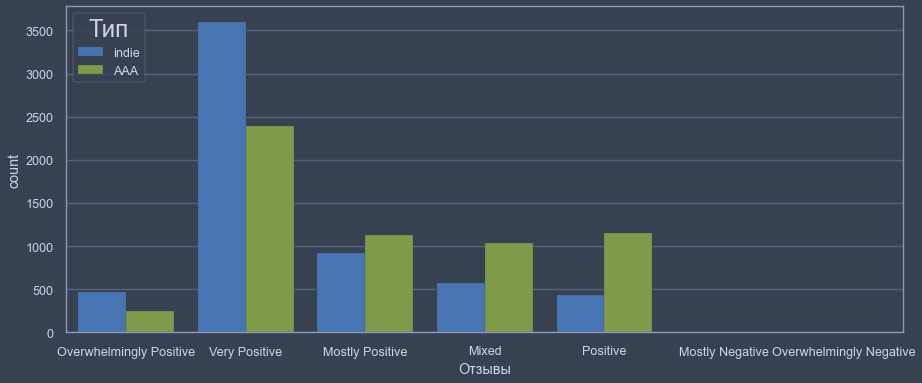

In [183]:
jtplot.style(context='notebook', ticks=True, grid=True, fscale=1.2, figsize=(15,6), theme='oceans16')
sns.countplot(x='Отзывы', hue='Тип', data = df)

## 3. Метки

### 3.1 Инди-игры и пиксельная графика — одно и тоже?

In [181]:
df3 = pd.DataFrame()

for idx in df.index:
    if 'Pixel Graphics' in df['Метки'][idx]:
        df3 = df3.append(df.loc[idx])
df3

,Название,Цена,Метки,Тип,Дата выхода,Отзывы,Рейтинг,Число отзывов
6,Vampire Survivors,73.0,"['Action Roguelike', 'Pixel Graphics', 'Bullet...",indie,2021-12-17,Overwhelmingly Positive,98%,"69,911"
19,Stardew Valley,299.0,"['Farming Sim', 'Life Sim', 'Pixel Graphics', ...",indie,2016-02-26,Overwhelmingly Positive,98%,"381,999"
23,The Binding of Isaac: Rebirth,449.0,"['Action Roguelike', 'Roguelike', 'Indie', 'Re...",indie,2014-11-04,Overwhelmingly Positive,97%,"173,230"
25,Terraria,610.0,"['Open World Survival Craft', 'Sandbox', 'Surv...",indie,2011-05-16,Overwhelmingly Positive,98%,"745,746"
26,Dead Cells,499.0,"['Roguelite', 'Roguelike', 'Pixel Graphics', '...",indie,2018-08-06,Overwhelmingly Positive,97%,"89,192"
...,...,...,...,...,...,...,...,...
11949,Black Widow: Recharged,809.0,"['Action', 'Arcade', 'Shooter', ""Shoot 'Em Up""...",AAA,2021-10-28,Positive,91%,12
11959,Corridor 7: Alien Invasion,259.0,"['Retro', 'Aliens', 'FPS', 'Shooter', 'Pixel G...",AAA,2021-08-06,Positive,100%,11
11965,Neko Dungeon | 喵酱迷城 | 喵醬迷城 | ねこダンジョン,195.0,"['JRPG', 'Sexual Content', 'Roguelite', 'Hidde...",AAA,2018-08-17,Mixed,46%,30
11975,Super Grave Snatchers,154.0,"['Villain Protagonist', 'Retro', 'Action RPG',...",AAA,2021-10-01,Positive,86%,36


Text(0.5, 1.0, 'Количество игр с тегом "Пиксельная графика"')

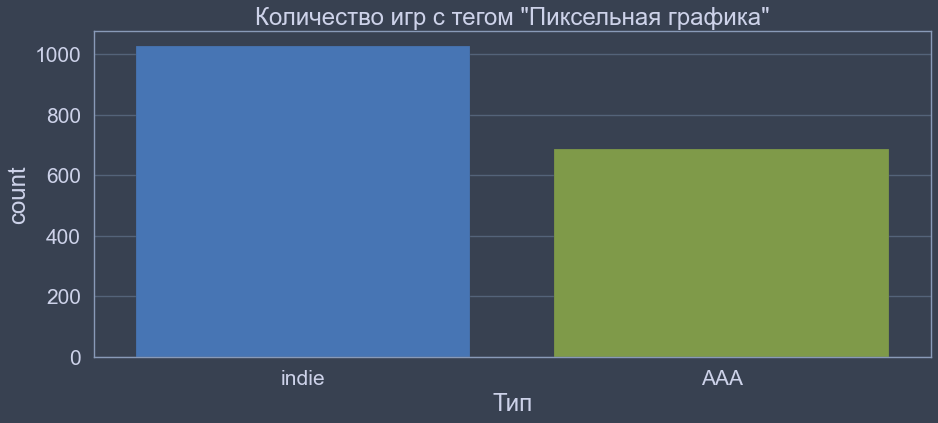

In [180]:
sns.countplot(df3['Тип']).set_title('Количество игр с тегом \"Пиксельная графика\"')